# TCR Immunology Metrics
From Porciello et al. (2022) we can extract the following relationships: 
- A high baseline diversity (entropy, richness) in blood is often linked to better response to immunotherapy.
- An increased clonality after treatment often reflects tumor-specific T cell expansion, associated with positive outcomes.
- A low evenness or DE50 (i.e., dominance by few clones) can indicate focused immune responses and correlate with clinical benefit.

The goal of this file is to compute those metrics with our patient dataset and cluster those patients by using these metrics to find patients groups.

## Imports


Uncomment and run the next cell if there are any errors when importing the libraries.

In [1]:
# ! pip install pyclustering
# ! pip install adjustText

### Importing libraries

In [ ]:
# IMPORTS
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

from scipy.stats import entropy # Shannon-entropy

from sklearn.preprocessing import StandardScaler
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.utils import calculate_distance_matrix

from kneed import KneeLocator

from adjustText import adjust_text

import os
import pickle


### Data dictionaries generation
Uncomment the data generation cell if the data files are not in the current file directory.

In [3]:
# # # DATA GENERATION CELL
# # Patient list ID
# pat_list = ['SARK012', 'SARK018', 'SARK019', 'SARK034', 'SARK017', 'SARK021', 'SARK025', 
#             'SARK041', 'SARK011', 'SARK027', 'SARK029', 'SARK032', 'SARK033', 'SARK037', 'SARK052', 'SARK059']
# # pat_list = ['SARK012', 'SARK018', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
#             # 'SARK041', 'SARK027', 'SARK029', 'SARK032', 'SARK033', 'SARK037', 'SARK059']

# # Read dataset
# file_path = 'TCR_seq_new.xlsx' 

# # Dictionaries with all the sequences
# all_counts = {}
# all_freq = {}

# # Dictionaries restricted to the top 100 sequences
# all_counts_100 = {}
# all_original_freq_100 = {}  # Original frequencies
# all_recalc_freq_100 = {}  # Frequencies calculated over the 100 top ranked sequences

# # Load the Excel file for each patient
# for i, pat in enumerate(pat_list):
#     # if pat == 'SARK017' or pat == 'SARK052' or pat =='SARK011':
#     #     continue
#     # else:
#         # Read excel sheet (equivalent to 1 patient)
#         sheet_index = 2*i
#         counts_df = pd.read_excel(file_path, sheet_name=sheet_index, engine='openpyxl')
#         freq_df = pd.read_excel(file_path, sheet_name=sheet_index+1, engine='openpyxl')

#         # Remove rows where 'CDR3.amino.acid.sequence' is NaN
#         counts_df = counts_df.dropna(subset=['CDR3.amino.acid.sequence'])
#         freq_df = freq_df.dropna(subset=['CDR3.amino.acid.sequence'])

#         # Select columns containing 'Day' (time points)
#         counts_df = counts_df.filter(regex='Day').copy()
#         freq_df = freq_df.filter(regex='Day').copy()

#         # Convert all values to numeric (important for summing later)
#         counts_df = counts_df.apply(pd.to_numeric, errors='coerce')
#         freq_df = freq_df.apply(pd.to_numeric, errors='coerce')

#         # Replace missing values with a 0 if the freq data has a 0
#         counts_df = counts_df.where(~(counts_df.isna()), 0)
#         freq_df = freq_df.where(~(freq_df.isna()), 0)

#         # Rename columns by extracting the numeric part and converting to integer
#         counts_df.columns = [int(col.split(' ')[1]) for col in counts_df.columns]
#         freq_df.columns = [int(col.split(' ')[1]) for col in freq_df.columns]

#         # Ensure numbers are in float type
#         counts_df = counts_df.astype(float)
#         freq_df = freq_df.astype(float)

#         counts_df["Total"] = counts_df.sum(axis=1)
#         freq_df["Total"] = freq_df.sum(axis=1)

#         # Add an ID column - To later be able to identify the sequences if necessary
#         counts_df['id'] = ['TCR_' + str(j + 1) for j in range(len(counts_df))]
#         freq_df['id'] = ['TCR_' + str(j + 1) for j in range(len(freq_df))]

#         # Sort by counts of 'Day 0' cols
#         counts_df = counts_df.sort_values(by=counts_df.columns[0], ascending=False, kind="mergesort").reset_index(drop=True)
#         freq_df = freq_df.sort_values(by=freq_df.columns[0], ascending=False, kind="mergesort").reset_index(drop=True)
    
#         # To check how many sequences we potentially are leaving out 
#         # print(f'\nFor {pat}:')
#         # print(f'    Number of seqs >0 on Day 0: {(counts_df.iloc[:, 0] > 0).sum()}')
#         # print(f'    Number of seqs >50 on Day 0: {(counts_df.iloc[:, 0] > 50).sum()}')
#         # print(f'    Number of seqs =0 on Day 0 BUT >50 on Total: {((counts_df.iloc[:, 0] == 0) & (counts_df.iloc[:, -2] > 50)).sum()}')

#         # Keep top 100 ranked sequences (Constrained on max num of seg for pat SARK018 = 101)
#         counts_100 = counts_df.copy().head(100)
#         counts_100_ids = counts_100["id"].tolist()
        
#         original_freq_100 = freq_df.copy().head(100)
#         freq_100_ids = original_freq_100["id"].tolist()
#         # print(f'    Top 100 seqs: {counts_100_ids}')

#         # Frequency recalculation for top 100 sequences
#         recalc_freq = counts_100.drop(columns=["Total"]).drop(columns=["id"]).div(counts_100.drop(columns=["Total"]).drop(columns=["id"]).sum(axis=0), axis=1) 
#         recalc_freq["id"] = counts_100["id"]
        
#         # Melt the dataframe for plotting (id, time, counts)
#         counts_m = counts_df.drop(columns=["Total"]).melt(id_vars='id', var_name='time', value_name='counts').copy()
#         freq_m = freq_df.drop(columns=["Total"]).melt(id_vars='id', var_name='time', value_name='counts').copy()
        
#         counts_100_m = counts_100.drop(columns=["Total"]).melt(id_vars='id', var_name='time', value_name='counts').copy()
#         original_freq_100_m = original_freq_100.drop(columns=["Total"]).melt(id_vars='id', var_name='time', value_name='counts').copy()
#         recalc_freq_100_m = recalc_freq.melt(id_vars='id', var_name='time', value_name='counts').copy()
        
#         # Store in dictionary
#         all_counts[pat] = counts_m
#         all_freq[pat] = freq_m

#         all_counts_100[pat] = counts_100_m
#         all_original_freq_100[pat] = original_freq_100_m
#         all_recalc_freq_100[pat] = recalc_freq_100_m
#         # if pat=='SARK021':
#         #     print(recalc_freq_100_m)

# # Function to save the dictionaries to disk
# def save_dictionaries_to_disk(dictionaries, file_paths):
#     """
#     Save dictionaries to disk using pickle.

#     Parameters:
#     - dictionaries (list): List of dictionaries to save.
#     - file_paths (list): List of file paths where each dictionary will be saved.
#     """
#     for dictionary, file_path in zip(dictionaries, file_paths):
#         with open(file_path, 'wb') as file:
#             pickle.dump(dictionary, file)
#             print(f"Saved to {file_path}")
    
# # List of dictionaries to save
# dictionaries_to_save = [all_counts, all_freq, all_counts_100, all_original_freq_100, all_recalc_freq_100]
# # List of corresponding file paths
# file_paths = ['all_counts.pkl', 'all_freq.pkl', 'all_counts_100.pkl', 'all_original_freq_100.pkl', 'all_recalc_freq_100.pkl']

# # Save the dictionaries
# save_dictionaries_to_disk(dictionaries_to_save, file_paths)



### Data dictionaries loading
Run the next cells if the data files are already generated.

In [ ]:
# Function to load the dictionaries from disk
def load_dictionaries_from_disk(file_paths):
    """
    Load dictionaries from disk using pickle.

    Parameters:
    - file_paths (list): List of file paths to load dictionaries from.

    Returns:
    - List of loaded dictionaries.
    """
    loaded_dictionaries = []
    for file_path in file_paths:
        with open(file_path, 'rb') as file:
            loaded_dict = pickle.load(file)
            loaded_dictionaries.append(loaded_dict)
            print(f"Loaded from {file_path}")
    return loaded_dictionaries

# List of file paths to load from
file_paths_to_load = ['all_counts.pkl', 'all_freq.pkl'] 


# Load the dictionaries
loaded_dictionaries = load_dictionaries_from_disk(file_paths_to_load)

# Unpack the loaded dictionaries
all_counts, all_freq = loaded_dictionaries


Loaded from all_counts.pkl
Loaded from all_freq.pkl


Next, delete excluded patients from our data. 

In [8]:
# Delete excluded patients
excluded_patients = ["SARK017", "SARK011", "SARK052"]
all_freq = {pat: df for pat, df in all_freq.items() if pat not in excluded_patients}
all_counts = {pat: df for pat, df in all_counts.items() if pat not in excluded_patients}

## Auxiliary functions
### TCR metrics
Here we define the functions to compute the metrics:

In [9]:
def adapted_gini_normalized(freqs):
    """
    Compute the normalized Adapted Gini coefficient (AG) from Rousseau et al. (1999).
    Input:
        freqs: array-like, clone frequencies (not necessarily normalized)
    Returns:
        Normalized AG value in [0, 1]
    """
    freqs = np.array(freqs)
    freqs = freqs[freqs > 0]  # remove zeros
    norm_freqs = freqs / freqs.sum()
    sorted_desc = np.sort(norm_freqs)[::-1]  # sort descending
    S = len(sorted_desc)
    ag_raw = 2 * np.sum((np.arange(1, S + 1)) * sorted_desc) - 1
    ag_normalized = (2 / np.pi) * np.arctan(ag_raw)
    return ag_normalized

In [10]:
def compute_tcr_metrics(freq_df):
    results = []

    for time in sorted(freq_df['time'].unique()):
        df_time = freq_df[freq_df['time'] == time]
        freqs = df_time['counts'].values
        freqs = freqs[freqs > 0]
        total = freqs.sum()

        if total == 0:
            continue  # skip empty timepoints

         # --- Normalization check ---
        total = freqs.sum()
        if not np.isclose(total, 1.0, atol=1e-3):
            norm_freqs = freqs / total
            print('Freqs not normalised. Normalizing now...')
        else:
            norm_freqs = freqs

        richness = len(freqs)

        # Shannon entropy
        shannon_entropy = entropy(norm_freqs, base=2)

        # Pielou's index (normalized entropy)
        pielou_index = shannon_entropy / np.log2(richness) if richness > 1 else 0

        # Clonality = 1 - Pielou
        clonality = 1 - pielou_index if richness > 1 else 0

        # Inverse Simpson index
        inv_simpson = 1 / np.sum(norm_freqs ** 2)

        # Gini–Simpson index (1 - Simpson's dominance index)
        gini_simpson_index = 1 - np.sum(norm_freqs ** 2)

        # Adapted Gini coefficient
        gini_coefficient = adapted_gini_normalized(norm_freqs)

        # DE50: number of top clones that make up 50% of frequency
        cum_freqs = np.cumsum(np.sort(norm_freqs)[::-1])
        try:
            de50 = np.argmax(cum_freqs >= 0.5) + 1
        except:
            de50 = np.nan

        results.append({
            'time': time,
            'richness': richness,
            'shannon_entropy': shannon_entropy,
            'pielou_index': pielou_index,
            'clonality': clonality,
            'inverse_simpson': inv_simpson,
            'gini_simpson_index': gini_simpson_index,
            'gini_coefficient': gini_coefficient,
            'DE50': de50
        })

    return pd.DataFrame(results)


In [11]:
# Function to combine metrics from all patients into one DataFrame
def combine_all_metrics(all_metrics):
    combined = []
    for pat, df in all_metrics.items():
        df = df.copy()
        df['patient'] = pat
        combined.append(df)
    return pd.concat(combined, ignore_index=True)

### Plotting functions
And next, we define the functions that will be used for plotting the results.

In [12]:
plt.rcParams.update({
    "font.size": 15,       # Default text size
    "axes.titlesize": 17,  # Title size
    "axes.labelsize": 15,  # X and Y label size
    "xtick.labelsize": 12, # X tick labels
    "ytick.labelsize": 13, # Y tick labels
    "legend.fontsize": 15,  # Legend text size
    "lines.linewidth": 3  # Increase line thickness
})

In [13]:
def save_figure(fig, file_prefix,foldername=None):
    current_path = os.getcwd()
    if foldername==None:
        save_folder = os.path.join(current_path, f'Results/TCR metrics')
    else:
        save_folder = os.path.join(current_path, f'Results/TCR metrics/{foldername}')
    os.makedirs(save_folder, exist_ok=True)
    png_path = os.path.join(save_folder, f"{file_prefix}.png")
    pdf_path = os.path.join(save_folder, f"{file_prefix}.pdf")
    fig.savefig(png_path, bbox_inches='tight')
    fig.savefig(pdf_path, bbox_inches='tight')


In [14]:
# Function to plot a chosen metric over time for all patients
def plot_metric_over_time(all_metrics, metric_name):
    fig = plt.figure(figsize=(10, 5))
    
    # Get a "tab20" colormap with as many distinct colors as there are patients
    # (If you have >20 patients, it will still work but eventually reuse colors)
    cmap = plt.cm.get_cmap('tab20', len(all_metrics))

    for i, (pat, df) in enumerate(all_metrics.items()):
        df_sorted = df.sort_values(by='time')
        # Pick a unique color from the palette
        color = cmap(i)
        plt.plot(
            df_sorted['time'], 
            df_sorted[metric_name], 
            marker='o', 
            label=pat,
            color=color
        )

    # Set the font sizes for all elements
    plt.xlabel('Time', fontsize=18)
    plt.ylabel(metric_name.replace('_', ' ').title(), fontsize=18)
    # plt.title(f'{metric_name.replace("_", " ").title()} Over Time', fontsize=20)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    # Tight layout to avoid clipping
    plt.tight_layout()
    
    save_figure(fig, f'time_evolution_{metric_name}',foldername='Time evolution')
    
    plt.show()

In [15]:
def plot_difference_bar(df, metric, label):
    # Ensure values are numeric
    df = df.copy()
    df[metric] = pd.to_numeric(df[metric], errors='coerce')

    # Create color label column
    df['sign'] = df[metric].apply(lambda x: 'Increase' if x >= 0 else 'Decrease')

    # Define color palette
    palette = {
        'Increase': 'deepskyblue',
        'Decrease': 'red'
    }

    # Plot
    fig = plt.figure(figsize=(6, 3))
    ax = sns.barplot(data=df, x='patient', y=metric, hue='sign', dodge=False, palette=palette)

    plt.axhline(0, color='gray', linestyle='--')
    plt.ylabel(f"Δ {label}")
    plt.xlabel("Patient")  
    plt.xticks(rotation=45)

    # Remove legend
    ax.get_legend().remove()

    plt.tight_layout()
    save_figure(fig, f'delta_{metric}', foldername='Change in metrics')
    plt.show()


In [ ]:
def plot_pairplot_clusters(data, labels, patient_names, title='Pairplot Cluster Plot', foldername=None):
    """
    Create a pairplot of clustered data with patient labels on scatter plots.

    Parameters:
        data (ndarray or DataFrame): The patient-feature matrix (e.g., standardized metrics).
        labels (array-like): Cluster labels (same length as rows of data).
        patient_names (array-like): List of patient identifiers.
        title (str): Plot title (used for filename as well).
        foldername (str or None): Folder to save figure into using `save_figure`. If None, just display.
    """
    # Build dataframe
    # df = pd.DataFrame(data, columns=[f'Comp_{i+1}' for i in range(data.shape[1])])
    metric_columns = ['Richness', 'Shannon Entropy', 'Clonality', 'DE50',
                  'Gini Coefficient', 'Gini-Simpson Index', 'Inverse Simpson Index', 'Pielou Evenness']
    df = pd.DataFrame(data, columns=metric_columns)
    df['Cluster'] = labels.astype(str)
    df['Patient'] = patient_names

    # Create pairplot
    g = sns.pairplot(df, hue='Cluster', palette='tab10', diag_kind='auto', corner=True)

    # Add patient labels to lower triangle only
    # for i in range(len(df.columns) - 2):  # exclude Cluster and Patient columns
    #     for j in range(i + 1):  # lower triangle only
    #         if i != j:
    #             ax = g.axes[i, j]
    #             if ax is not None:
    #                 texts = []
    #                 for _, row in df.iterrows():
    #                     texts.append(ax.text(row[f'Comp_{j+1}'], row[f'Comp_{i+1}'], row['Patient'],
    #                                          fontsize=10, color='black'))
    #                 adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

    # Save the figure
    if foldername:
        suffix = title.replace(' ', '_').replace('=', '')
        save_figure(g, f"pairplot_{suffix}", foldername)

    plt.show()

In [49]:
def plot_metric_pair_clusters(k, x, y, results, features_df, label_col='patient'):
    """
    Plot a pair of metrics with cluster labels for a specific k from the results dict.
    
    Parameters:
        k (int): Number of clusters to extract from results.
        x, y (str): Column names for metrics to plot.
        results (dict): Dictionary of clustering results, keyed by k.
        features_df (DataFrame): DataFrame with patient info and metrics.
        label_col (str): Column for patient labels.
    """
    # Create a temporary copy of the dataframe to avoid altering the original
    df = features_df.copy()
    df['Cluster'] = results[k]['labels']  # get labels for this k

    f = plt.figure(figsize=(5, 4))
    ax = sns.scatterplot(data=df, x=x, y=y, hue='Cluster', palette='tab10', s=70)

    texts = []
    for _, row in df.iterrows():
        texts.append(plt.text(row[x], row[y], str(row[label_col]), fontsize=11))

    adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

    plt.xlabel(x.replace('_', ' ').title())
    plt.ylabel(y.replace('_', ' ').title())
    plt.tight_layout()
    save_figure(f, f"{x}_vs_{y}_k{k}", 'Clustering')
    plt.show()


In [51]:
def plot_metric_trajectories_by_cluster(combined_metrics_df, features_df, metric='clonality', cluster_col='cluster'):
    """
    Plot trajectories over time for a given metric, colored by cluster assignment.

    Parameters:
        combined_metrics_df (DataFrame): Longitudinal metrics data (with time, patient, etc.)
        features_df (DataFrame): Patient-level dataframe containing cluster assignments.
        metric (str): The metric to plot.
        cluster_col (str): Column in features_df that contains cluster labels.
    """
    # Merge cluster info into longitudinal data
    df = combined_metrics_df.merge(features_df[['patient', cluster_col]], on='patient', how='inner')

    # Setup
    fig = plt.figure(figsize=(8, 4))
    unique_clusters = sorted(df[cluster_col].unique())
    palette = sns.color_palette("Set2", len(unique_clusters))
    cluster_color_map = {}

    # Plot each patient colored by cluster
    for cluster_id, cluster_df in df.groupby(cluster_col):
        cluster_color = palette[int(cluster_id)]
        cluster_color_map[cluster_id] = cluster_color
        for patient_id, patient_df in cluster_df.groupby("patient"):
            patient_df = patient_df.sort_values("time")
            plt.plot(patient_df["time"], patient_df[metric], color=cluster_color, alpha=0.7)
            plt.text(patient_df["time"].max() + 1, patient_df[metric].iloc[-1], patient_id, fontsize=8, color=cluster_color)

    # Custom legend
    legend_elements = [
        Line2D([0], [0], color=color, lw=2, label=f'Cluster {clust}')
        for clust, color in cluster_color_map.items()
    ]
    plt.legend(handles=legend_elements, title="Clusters", loc='best')

    plt.title(f"{metric.replace('_', ' ').title()} Trajectories Colored by Cluster")
    plt.xlabel("Time")
    plt.ylabel(metric.replace('_', ' ').title())
    plt.tight_layout()

    # Save and show
    save_figure(fig, f"{metric}_trajectories_by_cluster", foldername='Metric by cluster')
    plt.show()


## Metric computation

In [16]:
# Use all sequences (not just top 100) for metrics
all_metrics = {pat: compute_tcr_metrics(freq_df) for pat, freq_df in all_freq.items()}

# Combine metrics into a single DataFrame for further analysis or export
combined_metrics_df = combine_all_metrics(all_metrics)

### Time evolution plots
First we view the evolution of each metric across all patients.

C:\Users\viola\AppData\Local\Temp\ipykernel_29396\2723850841.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(all_metrics))


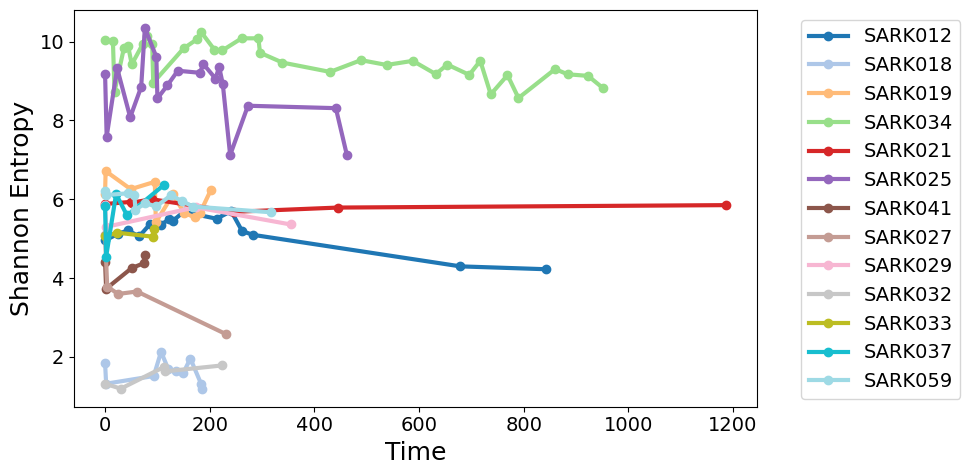

C:\Users\viola\AppData\Local\Temp\ipykernel_29396\2723850841.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(all_metrics))


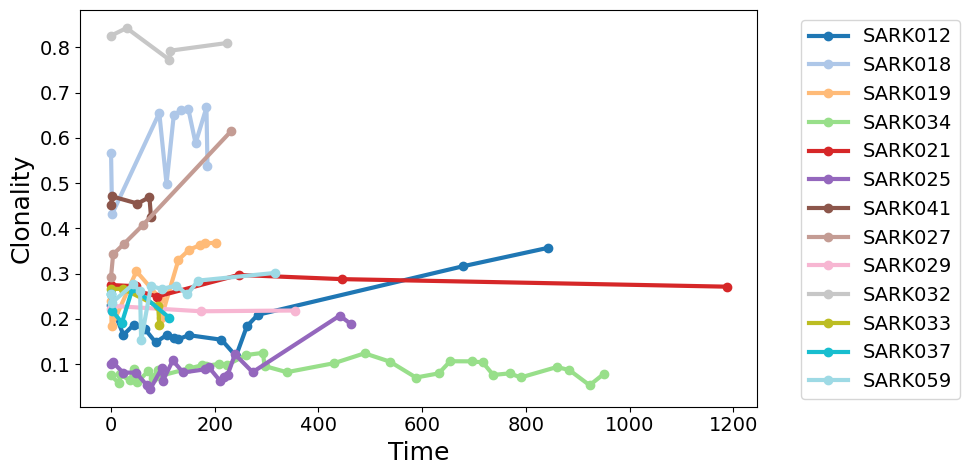

C:\Users\viola\AppData\Local\Temp\ipykernel_29396\2723850841.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(all_metrics))


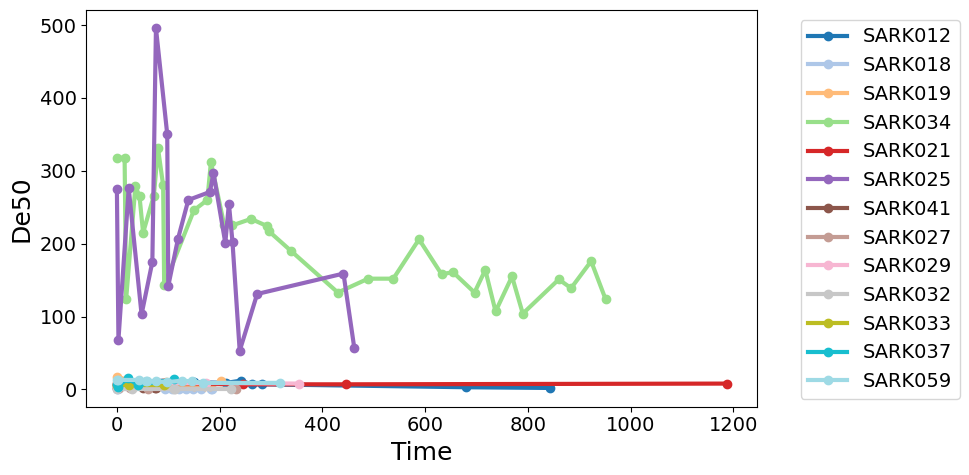

C:\Users\viola\AppData\Local\Temp\ipykernel_29396\2723850841.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(all_metrics))


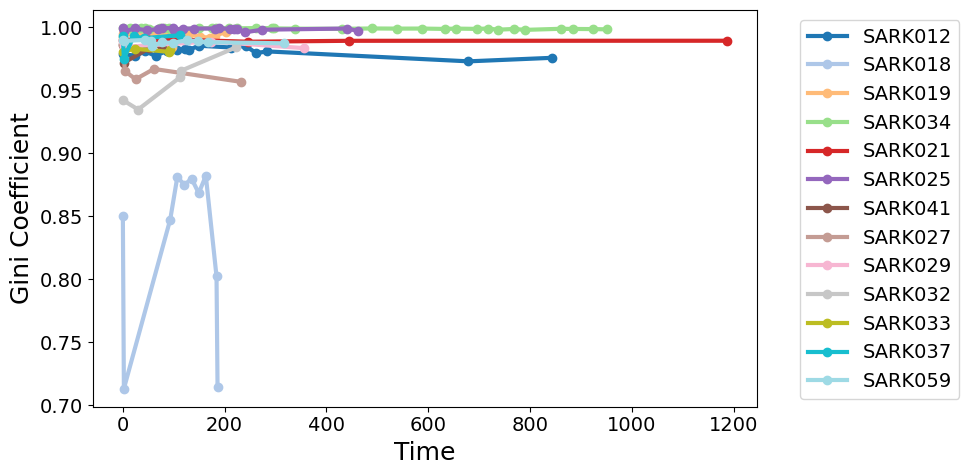

C:\Users\viola\AppData\Local\Temp\ipykernel_29396\2723850841.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(all_metrics))


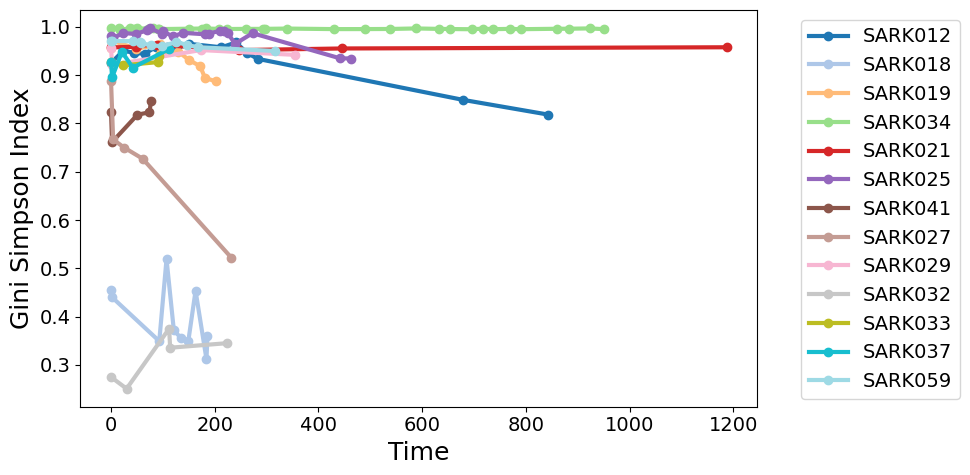

C:\Users\viola\AppData\Local\Temp\ipykernel_29396\2723850841.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(all_metrics))


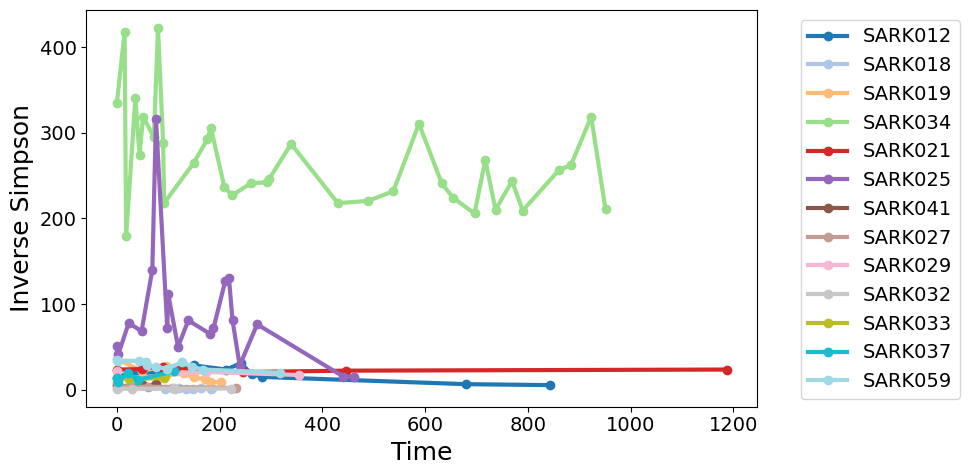

C:\Users\viola\AppData\Local\Temp\ipykernel_29396\2723850841.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(all_metrics))


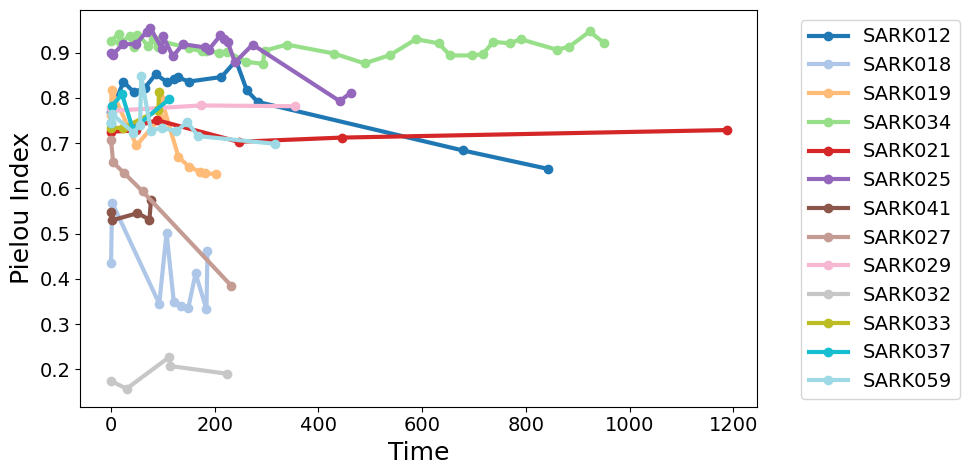

Combined Metrics Across Patients:
   time  richness  shannon_entropy  pielou_index  clonality  inverse_simpson  \
0     0        87         4.952647      0.768693   0.231307        13.362247   
1    24        70         5.119298      0.835220   0.164780        20.450145   
2    44        85         5.207479      0.812476   0.187524        18.497937   
3    65        71         5.054850      0.821961   0.178039        17.982193   
4    86        79         5.369021      0.851714   0.148286        23.828550   

   gini_simpson_index  gini_coefficient  DE50  patient  
0            0.925162          0.978761     6  SARK012  
1            0.951101          0.977513     7  SARK012  
2            0.945940          0.980905     7  SARK012  
3            0.944389          0.977273     7  SARK012  
4            0.958034          0.981588     9  SARK012  


In [ ]:
plot_metric_over_time(all_metrics, 'shannon_entropy')
plot_metric_over_time(all_metrics, 'clonality')
plot_metric_over_time(all_metrics, 'DE50')
plot_metric_over_time(all_metrics, 'gini_coefficient')
plot_metric_over_time(all_metrics, 'gini_simpson_index')
plot_metric_over_time(all_metrics, 'inverse_simpson')
plot_metric_over_time(all_metrics, 'pielou_index')


### Difference
Next, we view how these metrics have changed at the end of treatment (or of available data) in comparison to the situation these patients had before treatment. We first generate a new dataframe which compares this.

In [18]:
epsilon = 1e-8  # Small constant to avoid division by zero

# Group by patient
grouped = combined_metrics_df.groupby('patient')

comparisons = []

for patient, df in grouped:
    df_sorted = df.sort_values('time')
    first = df_sorted.iloc[0]
    last = df_sorted.iloc[-1]

    def safe_pct_change(first_val, last_val):
        denom = first_val if abs(first_val) > epsilon else epsilon
        return 100 * (last_val - first_val) / denom

    def compute_metrics(metric_name):
        return {
            f'{metric_name}_first': first[metric_name],
            f'{metric_name}_last': last[metric_name],
            f'{metric_name}_diff': last[metric_name] - first[metric_name],
            f'{metric_name}_pct_change': safe_pct_change(first[metric_name], last[metric_name])
        }

    metrics = ['richness', 'shannon_entropy', 'clonality', 'DE50',
               'gini_coefficient', 'gini_simpson_index', 'inverse_simpson', 'pielou_index']

    result = {
        'patient': patient,
        'time_first': first['time'],
        'time_last': last['time'],
    }

    for metric in metrics:
        result.update(compute_metrics(metric))

    comparisons.append(result)

comparison_df = pd.DataFrame(comparisons)


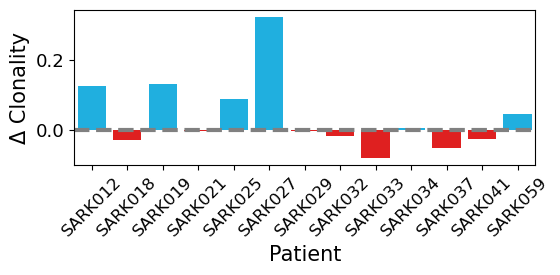

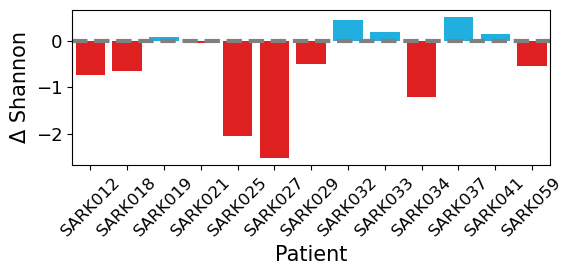

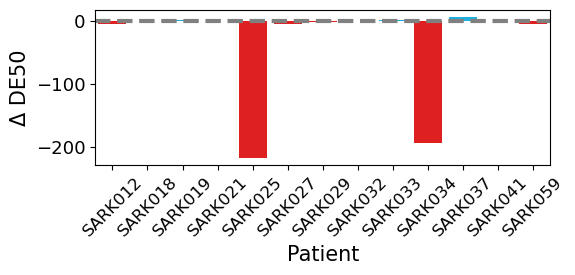

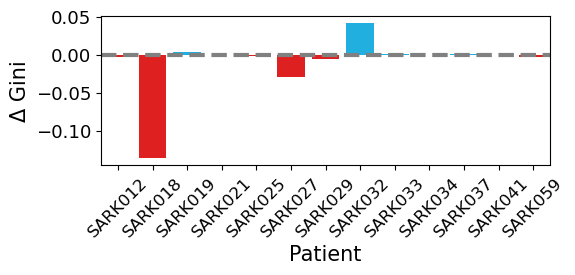

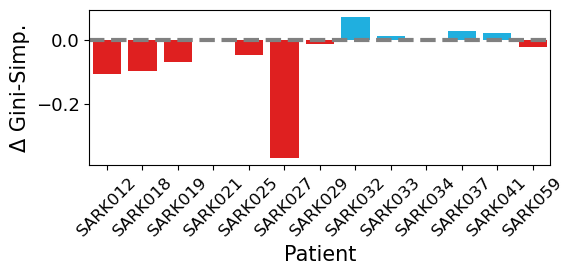

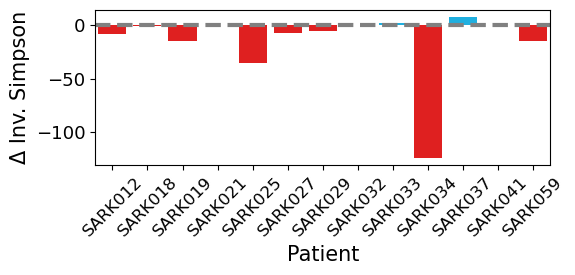

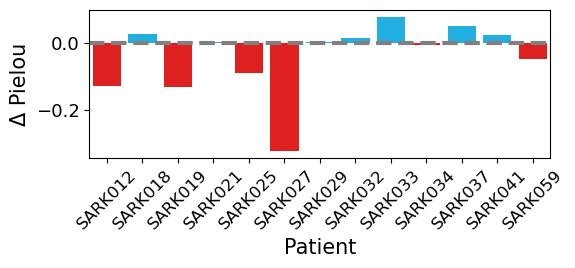

In [ ]:
plot_difference_bar(comparison_df,'clonality_diff','Clonality')
plot_difference_bar(comparison_df,'shannon_entropy_diff','Shannon')
plot_difference_bar(comparison_df,'DE50_diff', 'DE50')
plot_difference_bar(comparison_df,'gini_coefficient_diff','Gini')
plot_difference_bar(comparison_df,'gini_simpson_index_diff' ,'Gini-Simp.')
plot_difference_bar(comparison_df,'inverse_simpson_diff','Inv. Simpson')
plot_difference_bar(comparison_df,'pielou_index_diff','Pielou')


To see the change in percentage:

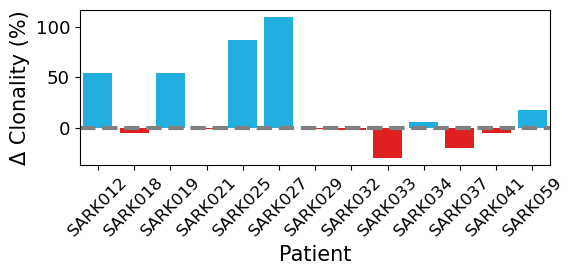

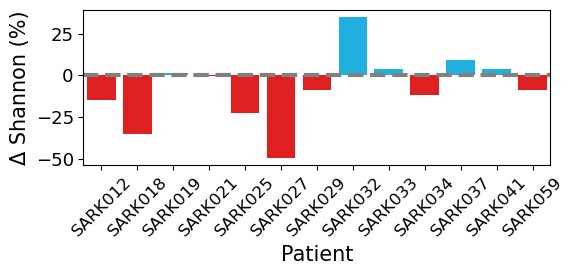

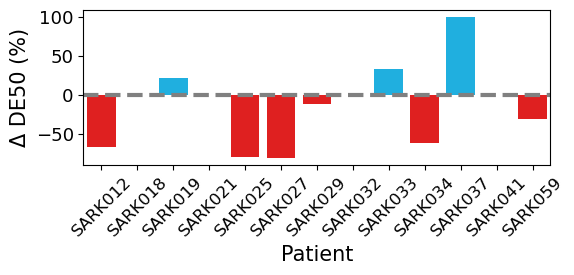

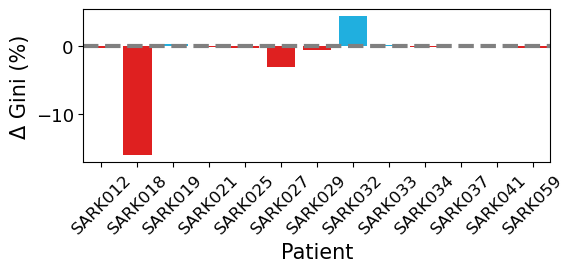

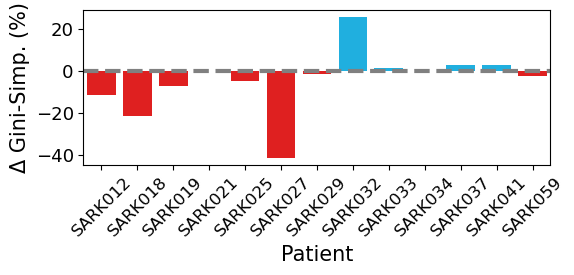

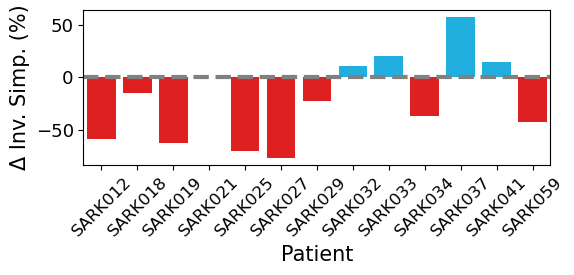

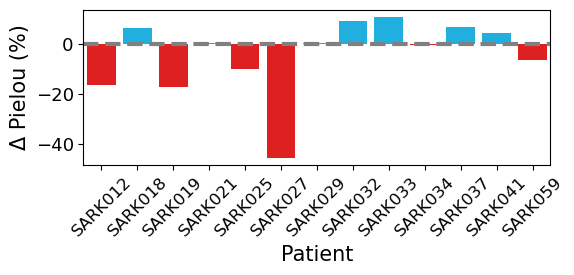

In [20]:
plot_difference_bar(comparison_df,'clonality_pct_change','Clonality (%)')
plot_difference_bar(comparison_df,'shannon_entropy_pct_change','Shannon (%)')
plot_difference_bar(comparison_df,'DE50_pct_change', 'DE50 (%)')
plot_difference_bar(comparison_df,'gini_coefficient_pct_change','Gini (%)')
plot_difference_bar(comparison_df,'gini_simpson_index_pct_change' ,'Gini-Simp. (%)')
plot_difference_bar(comparison_df,'inverse_simpson_pct_change','Inv. Simp. (%)')
plot_difference_bar(comparison_df,'pielou_index_pct_change','Pielou (%)')

## Clustering
Lastly, following the same clustering pipeline as for the Tucker decompositions, we try to cluster the patients according these metrics.

First we define some functions.

In [21]:
# K-Medoids function
def pyclustering_kmedoids(data, n_clusters):
    initial_medoids = list(np.random.choice(range(len(data)), n_clusters, replace=False))
    distance_matrix = calculate_distance_matrix(data)
    kmedoids_instance = kmedoids(distance_matrix, initial_medoids, data_type='distance_matrix')
    kmedoids_instance.process()

    clusters = kmedoids_instance.get_clusters()
    medoid_indices = kmedoids_instance.get_medoids()
    labels = np.empty(len(data), dtype=int)
    for cluster_idx, cluster_points in enumerate(clusters):
        labels[cluster_points] = cluster_idx

    return labels, medoid_indices

# WCSS calculation 
def calculate_wcss(data, labels, medoid_indices):
    distance_matrix = calculate_distance_matrix(data)
    wcss = 0
    for cluster_id in np.unique(labels):
        cluster_points = np.where(labels == cluster_id)[0]
        medoid_idx = medoid_indices[cluster_id]
        wcss += np.sum([distance_matrix[point][medoid_idx] for point in cluster_points])
    return wcss

Next, we prepare the data for the clustering method. We use the final timepoint metrics for clustering because they reflect the patient's immune status after treatment, which is directly relevant to outcomes. Using these snapshot values avoids instability in percent changes and allows clearer biological interpretation.


C:\Users\viola\AppData\Local\Temp\ipykernel_29396\3350680874.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  features = grouped.apply(lambda df: df.sort_values('time').iloc[-1]).reset_index(drop=True)


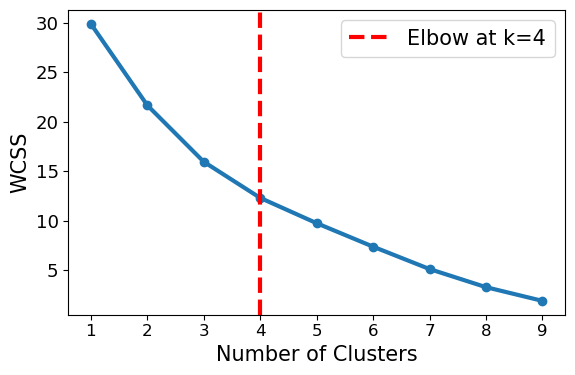

In [22]:
# Build patient-feature matrix from last timepoint
grouped = combined_metrics_df.groupby('patient')
features = grouped.apply(lambda df: df.sort_values('time').iloc[-1]).reset_index(drop=True)

# Select metrics and scale them
metric_columns = ['richness', 'shannon_entropy', 'clonality', 'DE50',
                  'gini_coefficient', 'gini_simpson_index', 'inverse_simpson', 'pielou_index']
X = features[metric_columns].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Try multiple k values
results = {}  
for k in range(1, 10):  
    labels, medoids = pyclustering_kmedoids(X_scaled, k)
    wcss = calculate_wcss(X_scaled, labels, medoids)
    results[k] = {
        'labels': labels,
        'medoids': medoids,
        'wcss': wcss
    }

# Plot WCSS and find elbow
cluster_numbers = list(results.keys())
wcss_values = [results[k]['wcss'] for k in cluster_numbers]

kneedle = KneeLocator(cluster_numbers, wcss_values, curve='convex', direction='decreasing')
elbow_cluster = kneedle.knee or cluster_numbers[np.argmin(wcss_values)]

fig = plt.figure(figsize=(6, 4))
plt.plot(cluster_numbers, wcss_values, marker='o')
if elbow_cluster:
    plt.axvline(elbow_cluster, color='red', linestyle='--', label=f'Elbow at k={elbow_cluster}')
    plt.legend()
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.tight_layout()
plt.show()

# Assign final cluster labels
features['cluster'] = results[elbow_cluster]['labels']

# Save WCSS plot
save_figure(fig, 'WCSS_metrics', foldername='Clustering')


Finally, we plot the clusters for the best found k.

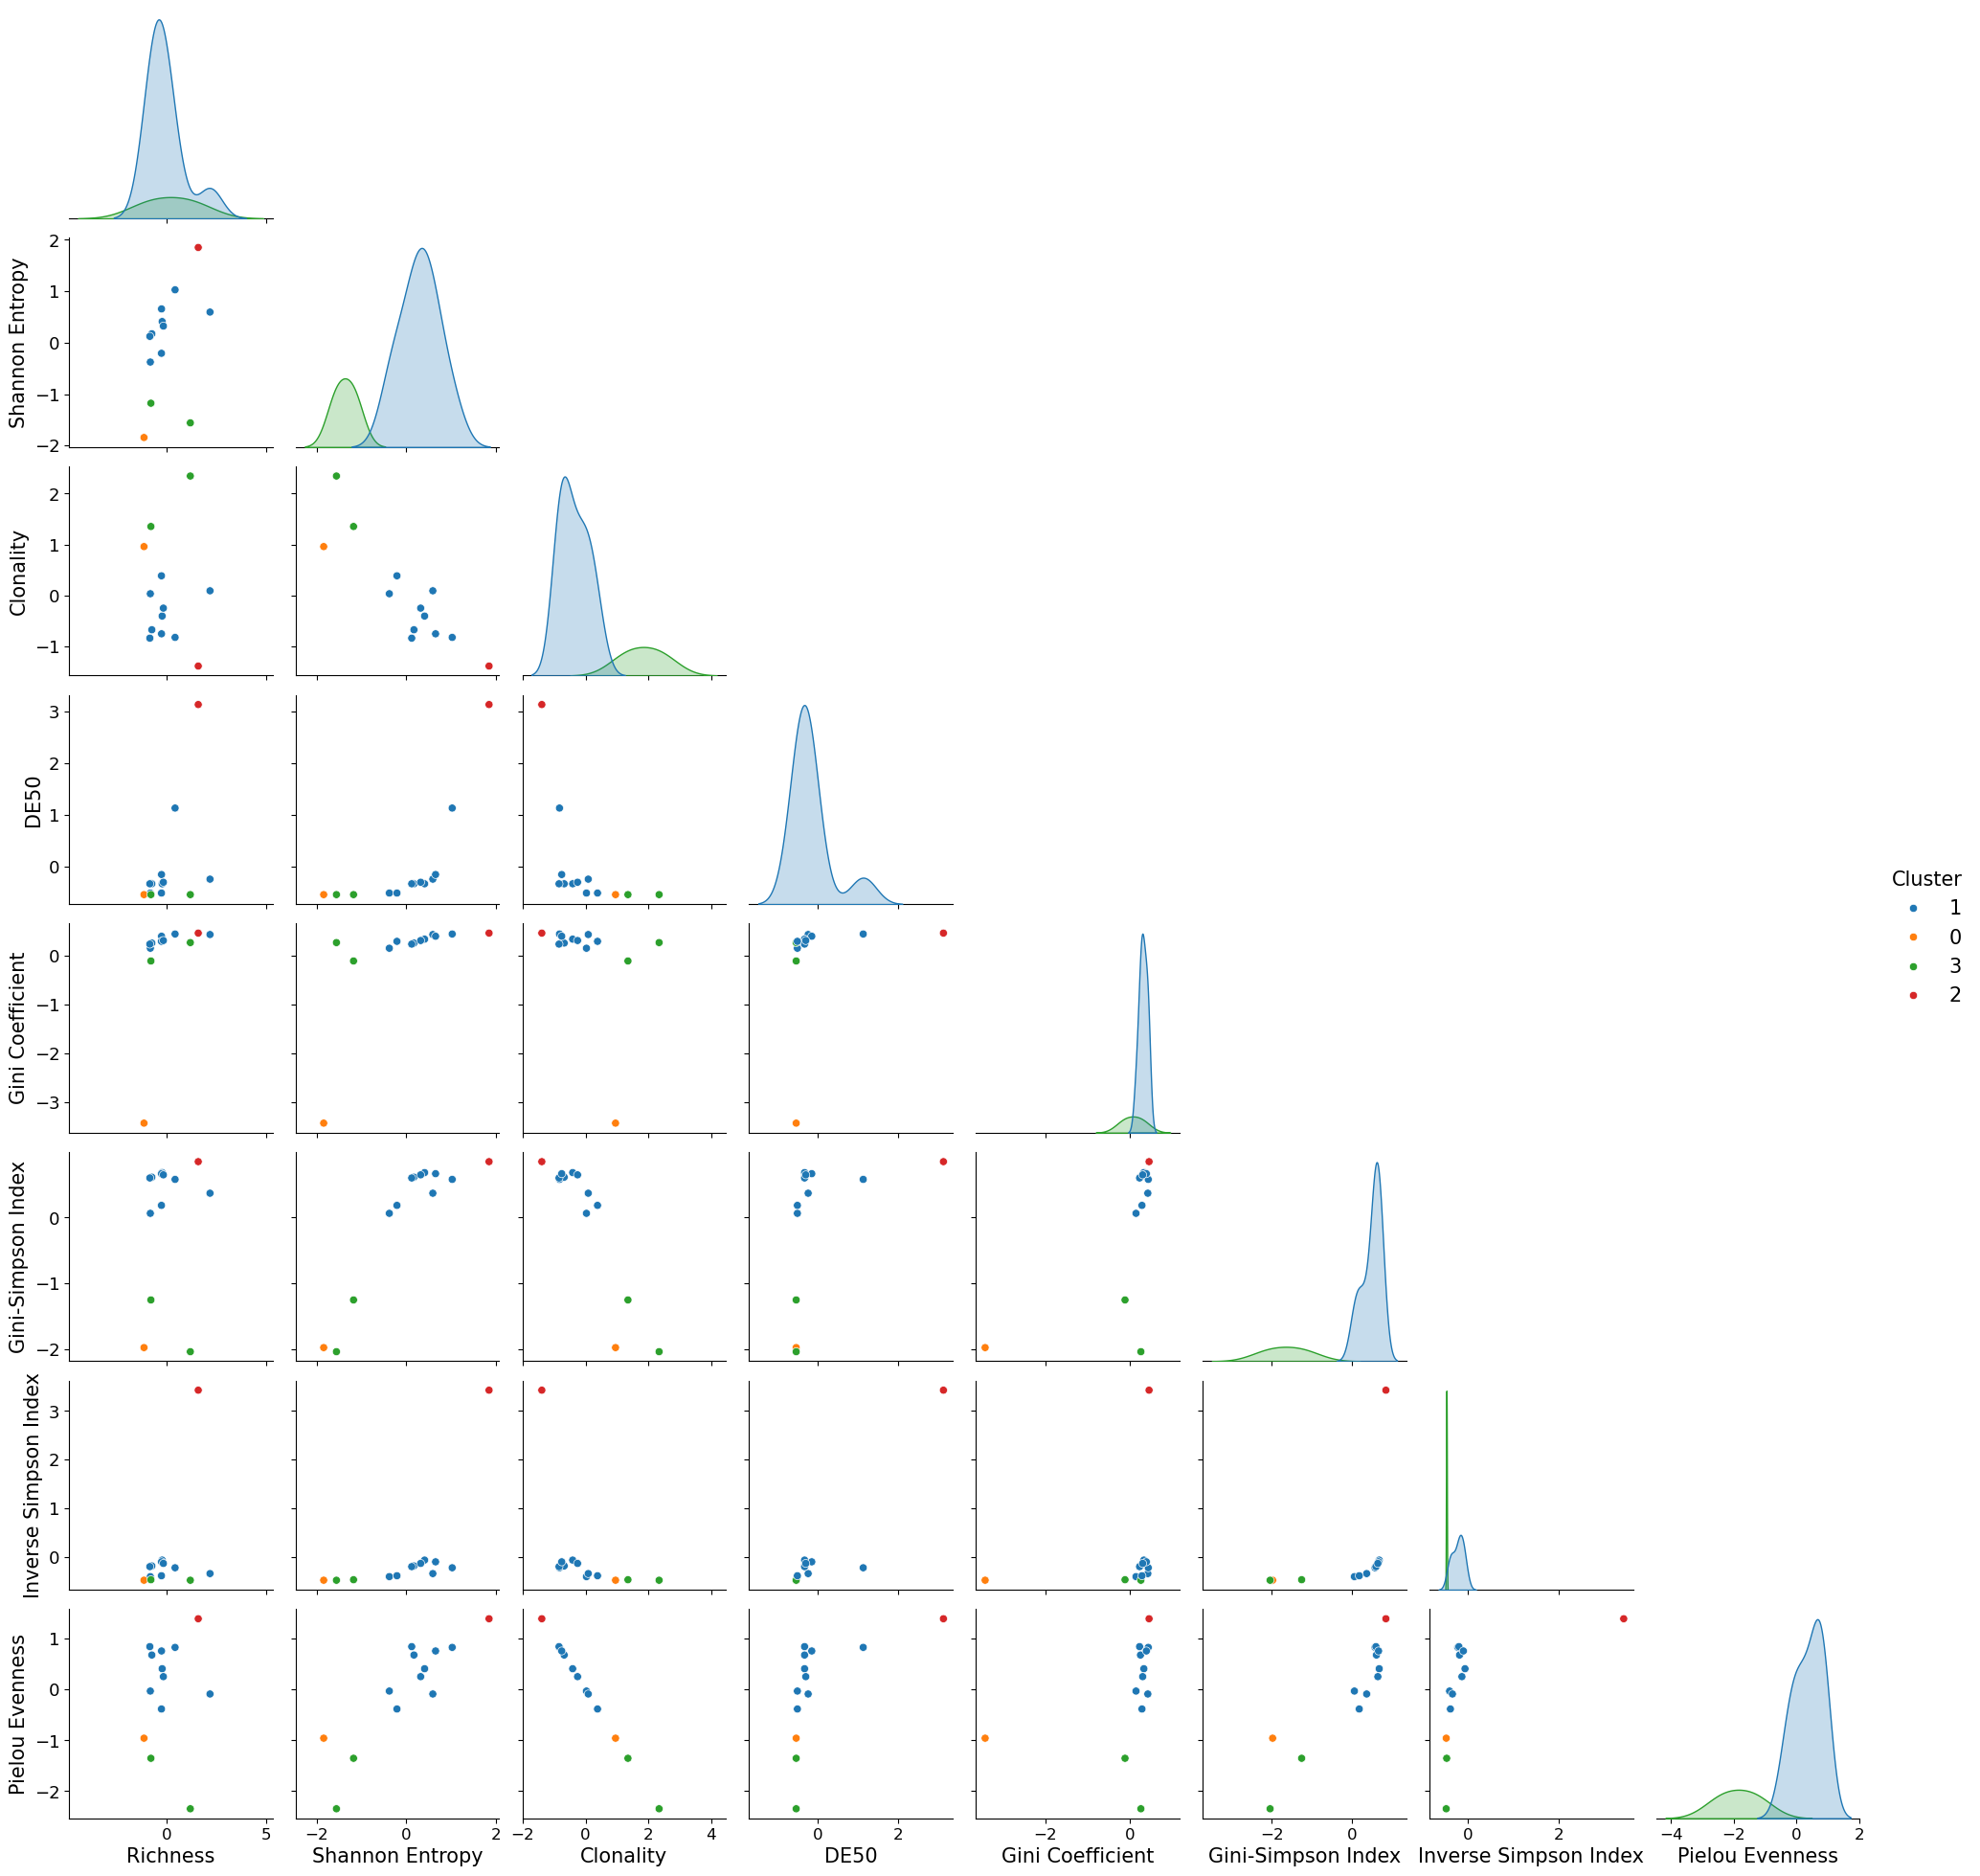

In [24]:
k=4 # Set the number of clusters to plot
plot_pairplot_clusters(
    data=X_scaled,
    labels=results[k]['labels'],               
    patient_names=features['patient'],         
    title=f'TCR_Clustering_k={k}',                
    foldername='Clustering'                    
)


Let's plot only a pair of features for better visualization.

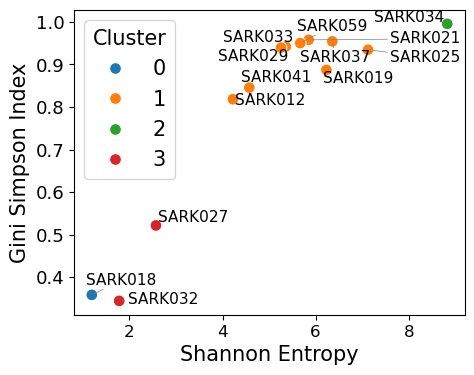

In [50]:
plot_metric_pair_clusters(
    k=4,
    x='shannon_entropy',
    y='gini_simpson_index',
    results=results,
    features_df=features
)


Now let's plot some metrics by cluster

Plotting richness trajectories...


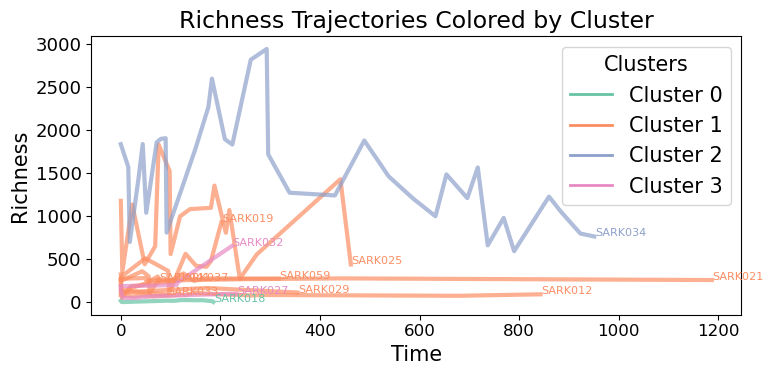

Plotting shannon_entropy trajectories...


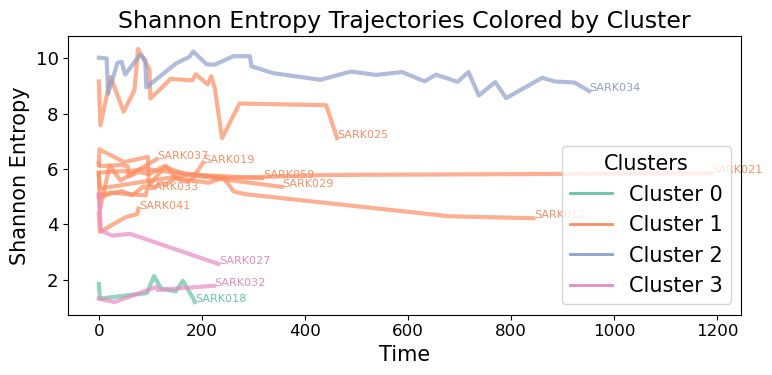

Plotting clonality trajectories...


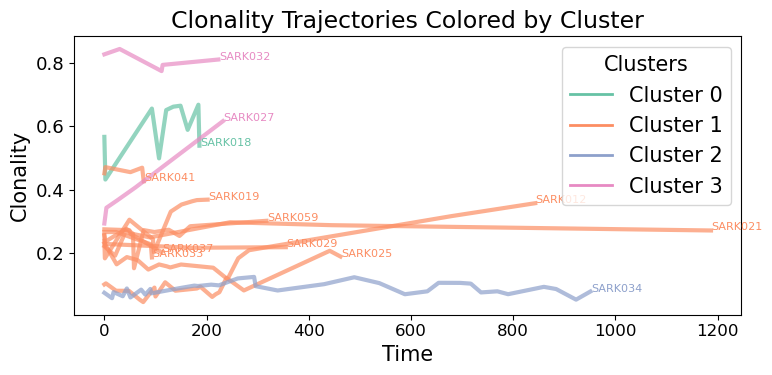

Plotting DE50 trajectories...


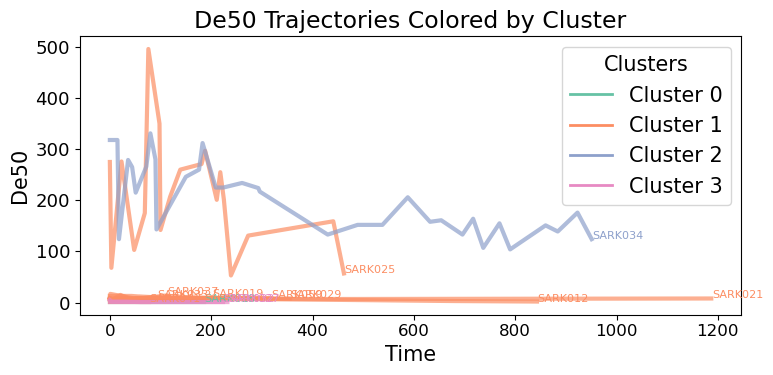

Plotting gini_coefficient trajectories...


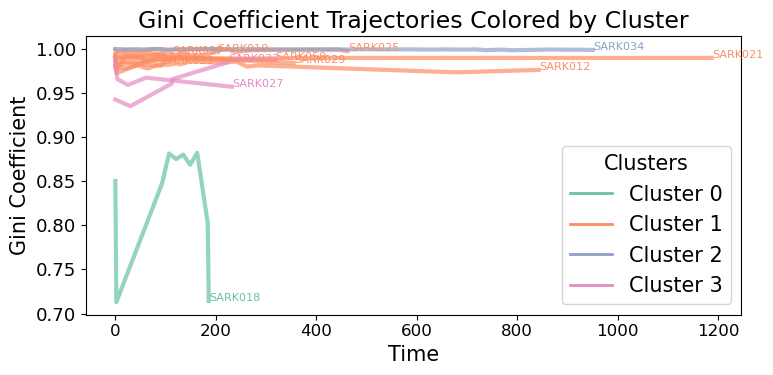

Plotting gini_simpson_index trajectories...


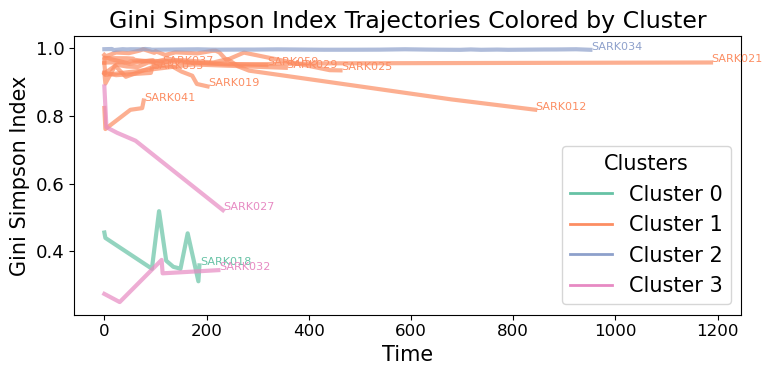

Plotting inverse_simpson trajectories...


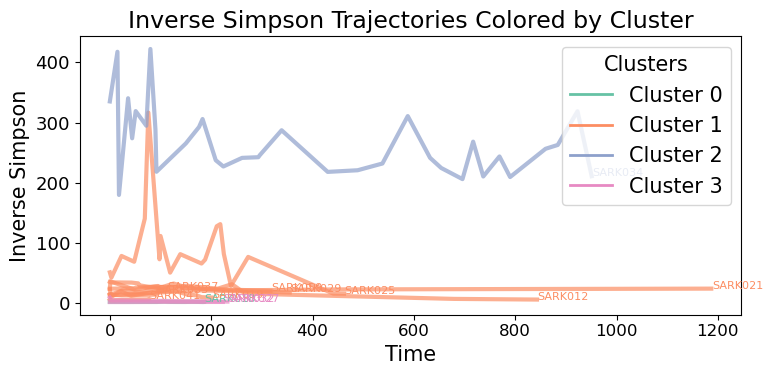

Plotting pielou_index trajectories...


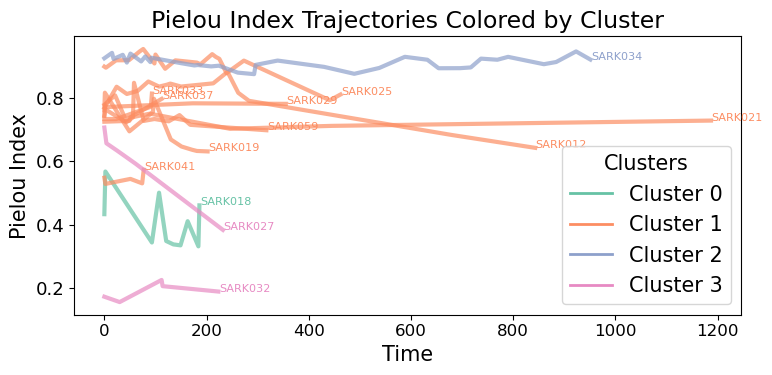

In [52]:
# Assign cluster labels (make sure this is done once)
features['cluster'] = results[4]['labels']  # replace 4 with your chosen k

# Define the metrics you want to plot
metric_columns = [
    'richness', 'shannon_entropy', 'clonality', 'DE50',
    'gini_coefficient', 'gini_simpson_index', 'inverse_simpson', 'pielou_index'
]

# Loop over metrics and generate a plot for each
for metric in metric_columns:
    print(f"Plotting {metric} trajectories...")
    plot_metric_trajectories_by_cluster(
        combined_metrics_df,
        features,
        metric=metric,
        cluster_col='cluster'
    )


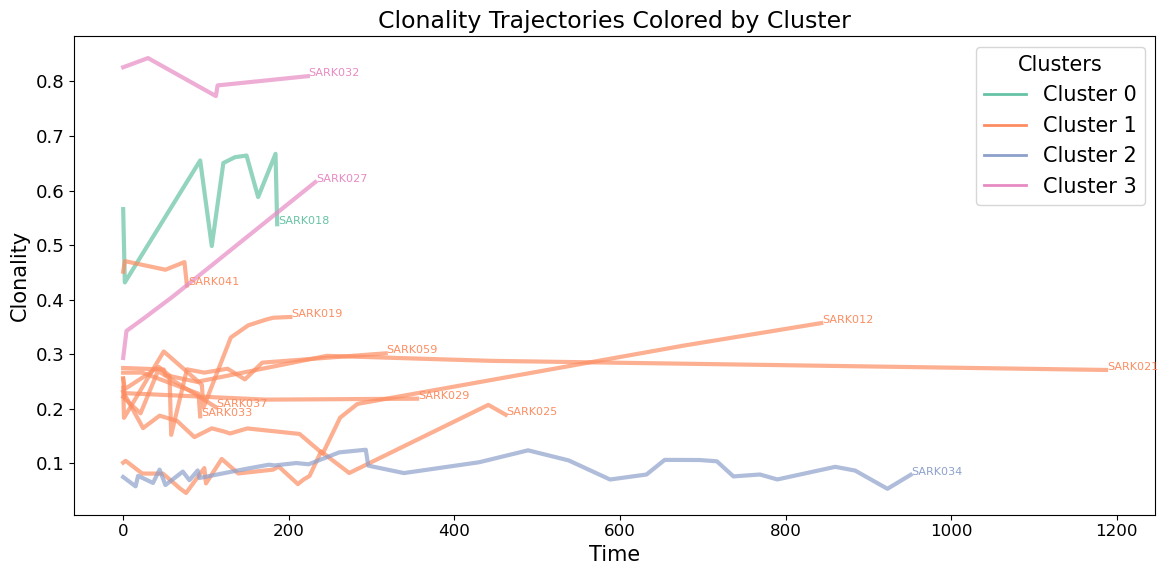

In [40]:
features['cluster'] = results[4]['labels']  # or whatever k you're using

plot_metric_trajectories_by_cluster(combined_metrics_df, features, metric='clonality', cluster_col='cluster')


# Saving results for cluster comparison

We generate the same results for a shor-list of patients to match those in the tensors for a proper comparison in another file `Cluster_comparison.ipynb`.

In [34]:
# Define patient lists as received from the Tucker notebook
pat_list_70 = ['SARK012', 'SARK018', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
                'SARK041', 'SARK027', 'SARK029', 'SARK032', 'SARK033', 'SARK037', 'SARK059']

pat_list_100 =['SARK012', 'SARK018', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
                'SARK027', 'SARK029', 'SARK032', 'SARK037', 'SARK059']

pat_list_200 = ['SARK012', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
            'SARK027', 'SARK029', 'SARK032', 'SARK059']

pat_list_300 = ['SARK012', 'SARK034', 'SARK021', 'SARK025', 
            'SARK029', 'SARK059']

patient_lists = {
    'tensor_70': pat_list_70,
    'tensor_100': pat_list_100,
    'tensor_200': pat_list_200,
    'tensor_300': pat_list_300
}

# Define the metric columns
metric_columns = ['richness', 'shannon_entropy', 'clonality', 'DE50',
                  'gini_coefficient', 'gini_simpson_index', 'inverse_simpson', 'pielou_index']

# Loop through each tensor key
for tensor_key, patient_subset in patient_lists.items():
    # print(f"\nRunning TCR clustering for patients in {tensor_key}...")

    # Step 1: Subset features to only the patients in the current tensor
    tcr_subset = features[features['patient'].isin(patient_subset)].copy()

    # Step 2: Standardize TCR metric values
    X = tcr_subset[metric_columns].values
    X_scaled = StandardScaler().fit_transform(X)

    # Step 3: Try multiple k values and save each
    if tensor_key=='tensor_300':
        for k in range(1, 7):  # adjust k range if needed
            labels, medoids = pyclustering_kmedoids(X_scaled, k)

            # Step 4: Save the clustering result for comparison
            df = pd.DataFrame({
                'patient': tcr_subset['patient'].values,
                'cluster': labels
            })
            df.to_csv(f'Clust_Results/labels_TCR_metrics_{tensor_key}_k{k}.csv', index=False)
    else:
        for k in range(1, 10):  # adjust k range if needed
            labels, medoids = pyclustering_kmedoids(X_scaled, k)

            # Step 4: Save the clustering result for comparison
            df = pd.DataFrame({
                'patient': tcr_subset['patient'].values,
                'cluster': labels
            })
            df.to_csv(f'Clust_Results/labels_TCR_metrics_{tensor_key}_k{k}.csv', index=False)
